# Self-Driving Car Engineer Nanodegree
## Project 4: Advanced Lane Lines

In [1]:
import os
import glob

import numpy as np
import cv2

import random
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

FIGSIZE = (16, 8)

In [2]:
# import helper functions implemented in a separate Python module for reducing code clutter inside this notebook
import helpers.calibration as calibration
import helpers.sobel as sobel
import helpers.color as color
import helpers.warp as warp

## Camera Calibration

Images for camera calibration are provided inside the `camera_cal/` folder.

In [193]:
# helper function to display images inline in a grid
def display(images, cols=None, maxcols=10, width=FIGSIZE[0], titles=None, callback=None):
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(fig1, 111,
                     nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                     axes_pad=(0.1, 0.4),
                    )

    for index, img in enumerate(images):
        if titles is not None:
            grid1[index].set_title(titles[index])
        if len(img.shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)
        if callback is not None:
            callback(grid1[index], index)

In [4]:
# find and load all camera calibration images
CAMERA_CAL = 'camera_cal'
cal_files = os.listdir(CAMERA_CAL)
cal_files = list(map(lambda f: os.path.join(CAMERA_CAL, f), cal_files))
cal_images = [ calibration.load_image(f) for f in cal_files ]
print('There are {} calibration images present'.format(len(cal_files)))

There are 20 calibration images present


In [5]:
cal_chessboards = [calibration.chessboard(img, draw=True)[2] for img in cal_images]

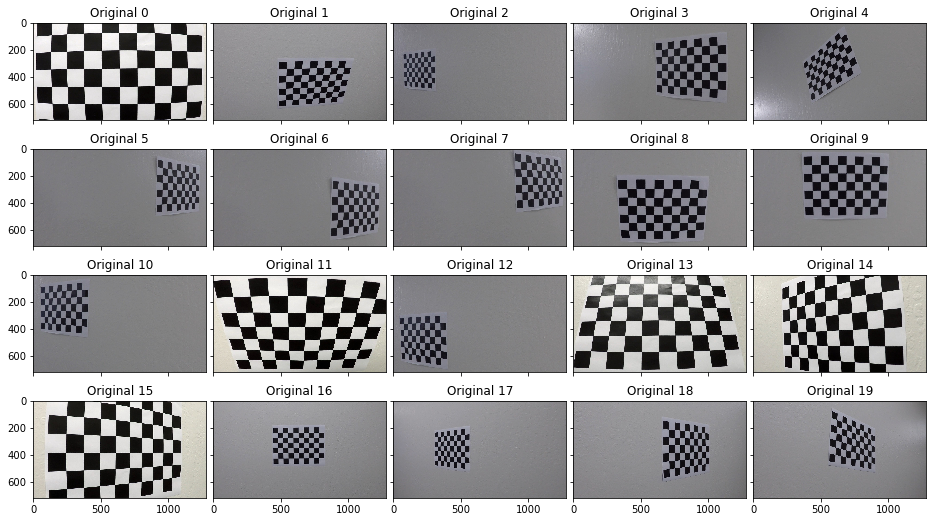

In [6]:
display(
    cal_images,
    cols=5,
    titles=['Original {}'.format(i) for i in range(len(cal_images))]
)

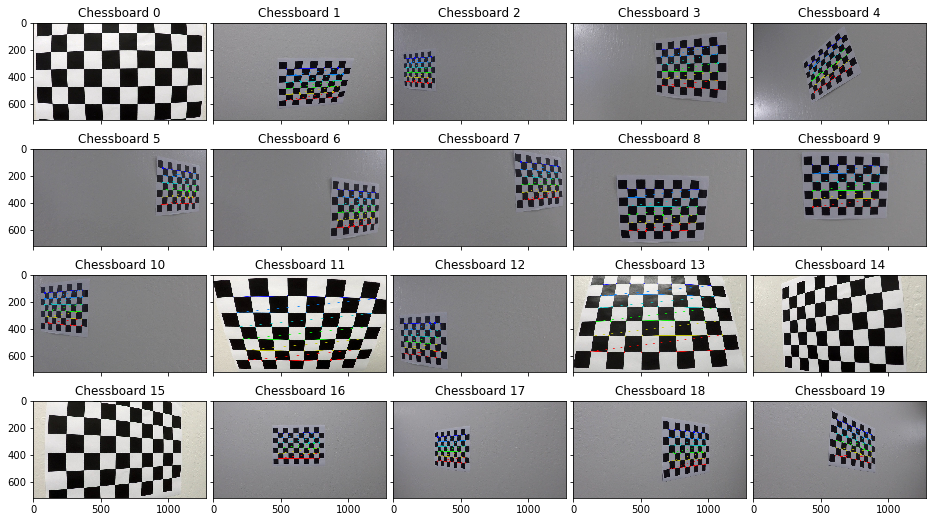

In [7]:
display(
    cal_chessboards,
    cols=5,
    titles=['Chessboard {}'.format(i) for i in range(len(cal_chessboards))]
)

#### Chessboard discovery rate
As can be observed, chessboard corners could not be identified on all calibration images. This is due to the fact that we are looking for a `9 x 6` chessboard, but not all necessary intersections are visible on the images. The top left photo, for example, lacks the bottom row. The bottom left photo lacks the top left intersections of the chessboard. The 15th photo (row 3, column 5) misses the top right corner needed.

## Calibrating the Camera

With the help of the discovered chessboard corners in the section above, it is now possible to calibrate the camera, i.e. retrieve the camera's transformation matrix `M`.

In [8]:
M, dist = calibration.calibrate(cal_images)
print('Camera matrix:', M)
print('Distortion coefficients:', dist)

Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficients: [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


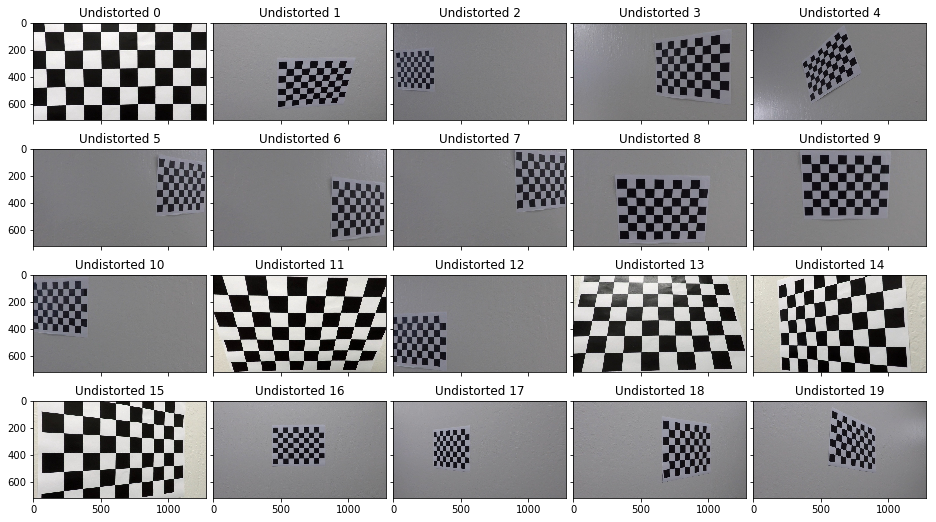

In [9]:
undist_images = [calibration.undistort(img, M, dist) for img in cal_images]
display(
    undist_images,
    cols=5,
    titles=['Undistorted {}'.format(i) for i in range(len(undist_images))]
)

### Comparing original and undistorted chessboard images

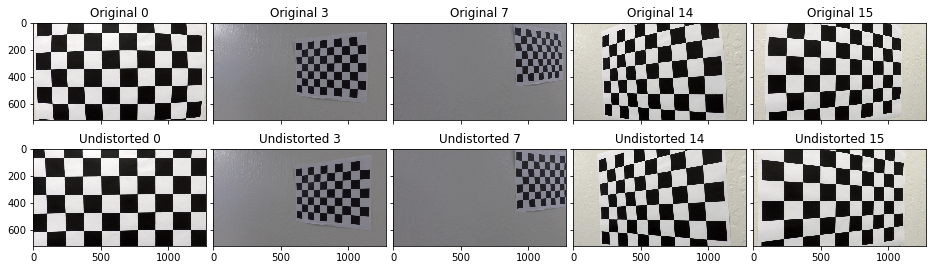

In [150]:
samples = (0, 3, 7, 14, 15)
compare = [z for i, z in enumerate(cal_images) if i in samples]
compare += [z for i, z in enumerate(undist_images) if i in samples]

display(
    compare,
    cols=5,
    titles=[
        'Original {}'.format(samples[i])
        for i in range(len(samples))
    ] + [
        'Undistorted {}'.format(samples[i])
        for i in range(len(samples))
    ]
)

## Finding Gradients

In [151]:
TEST_IMAGE_FOLDER = 'test_images'
test_image_filenames = os.listdir(TEST_IMAGE_FOLDER)
print('Found {} test images: {}'.format(len(test_image_filenames), ', '.join(test_image_filenames)))
test_image_filenames = [os.path.join(TEST_IMAGE_FOLDER, fname) for fname in test_image_filenames]

Found 8 test images: straight_lines1.jpg, straight_lines2.jpg, test1.jpg, test2.jpg, test3.jpg, test4.jpg, test5.jpg, test6.jpg


In [176]:
test_images = [calibration.load_image(fname) for fname in test_image_filenames]
test_images = [calibration.undistort(img, M, dist) for img in test_images]

for filename, img in zip(test_image_filenames, test_images):
    new_filename = os.path.join('undistorted', filename.split('/')[-1])
    mpimg.imsave(new_filename, img, format='jpg')

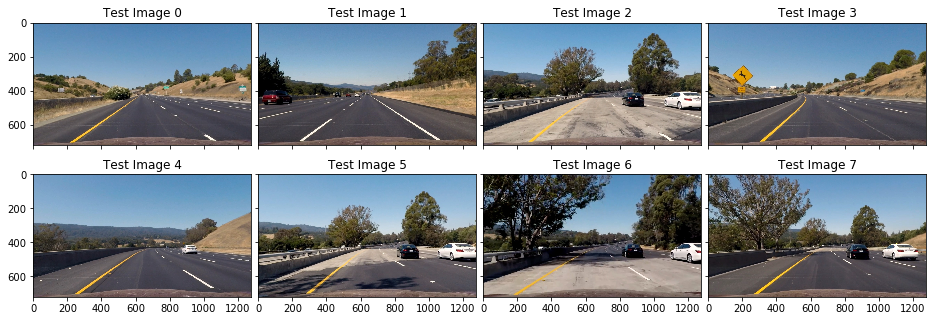

In [153]:
display(
    test_images,
    cols=len(test_images)//2,
    titles=['Test Image {}'.format(i) for i in range(len(test_images))]
)

In [154]:
test_image_subset = test_images[:3]

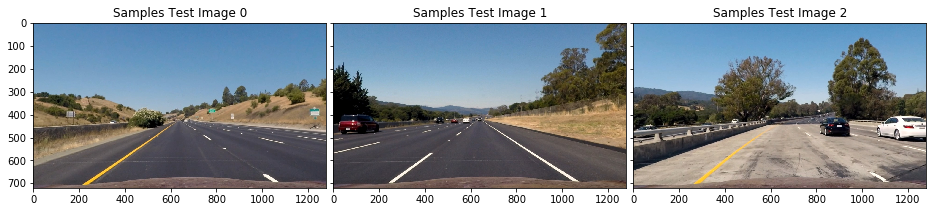

In [155]:
display(
    test_image_subset,
    titles=['Samples Test Image {}'.format(i) for i in range(len(test_images))]
)

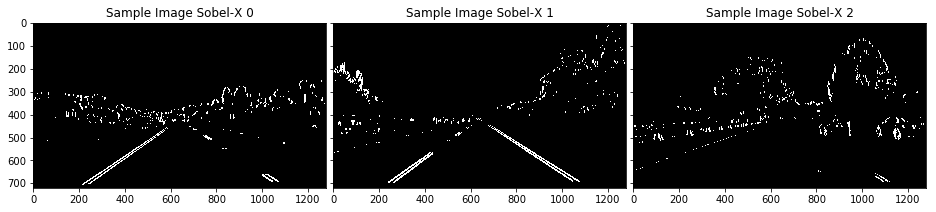

In [156]:
test_sobelx = [sobel.sobel(img, axis='x', threshold=(60,255), kernel=25) for img in test_image_subset]
display(
    test_sobelx,
    titles=['Sample Image Sobel-X {}'.format(i) for i in range(len(test_sobelx))]
)

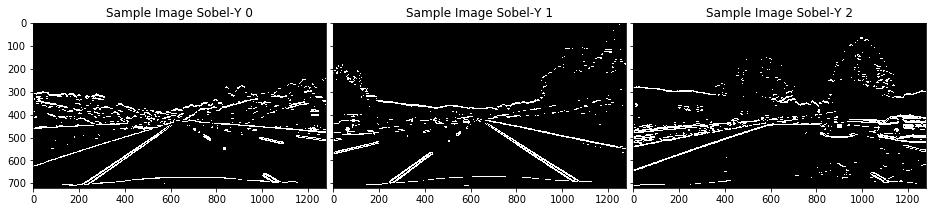

In [157]:
test_sobely = [sobel.sobel(img, axis='y', threshold=(50,255), kernel=25) for img in test_image_subset]
display(
    test_sobely,
    titles=['Sample Image Sobel-Y {}'.format(i) for i in range(len(test_sobely))]
)

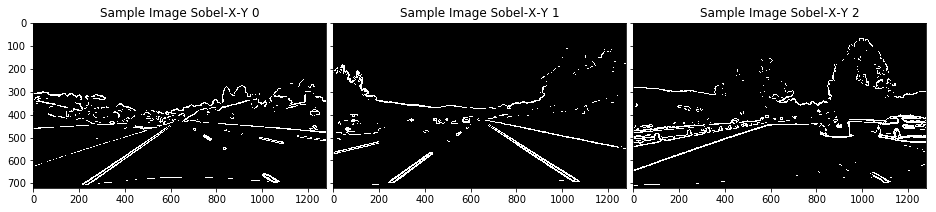

In [158]:
test_sobelxy = [sobel.sobel(img, axis='xy', threshold=(70,255), kernel=29) for img in test_image_subset]
display(
    test_sobelxy,
    titles=['Sample Image Sobel-X-Y {}'.format(i) for i in range(len(test_sobelxy))]
)

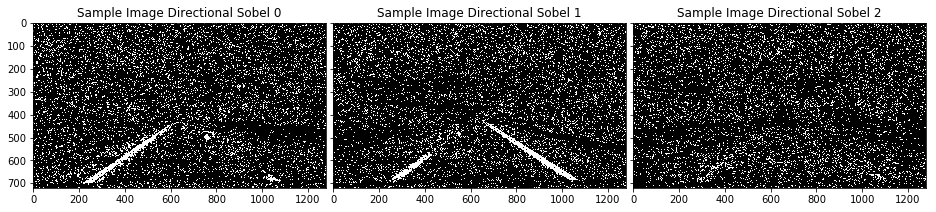

In [159]:
test_sobeld = [sobel.sobel(img, directional=True, threshold=(0.9,1.1), kernel=25) for img in test_image_subset]
display(
    test_sobeld,
    titles=['Sample Image Directional Sobel {}'.format(i) for i in range(len(test_sobeld))]
)

### Combined Sobel Edges

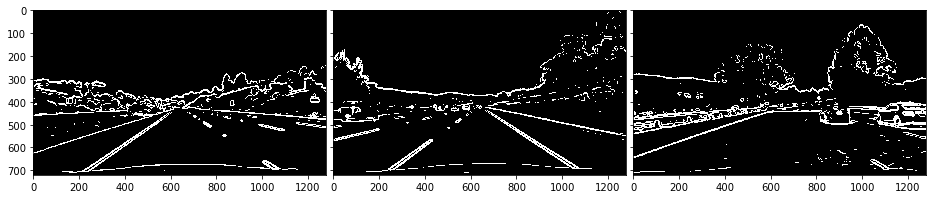

In [160]:
test_sobelxy = np.array(test_sobelxy)
test_sobelx = np.array(test_sobelx)
test_sobely = np.array(test_sobely)
test_sobeld = np.array(test_sobeld)

combined_sobel1 = color.combine_thresholds(test_sobelxy, test_sobelx, test_sobely)#, test_sobeld)
display(combined_sobel1)

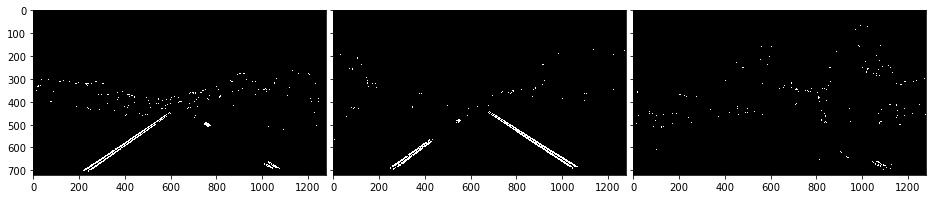

In [161]:
combined_sobel2 = np.zeros_like(test_sobeld)
combined_sobel2[
    (test_sobelxy == 1) & (test_sobeld == 1)
] = 1
display(combined_sobel2)

## Color Channels

### RGB

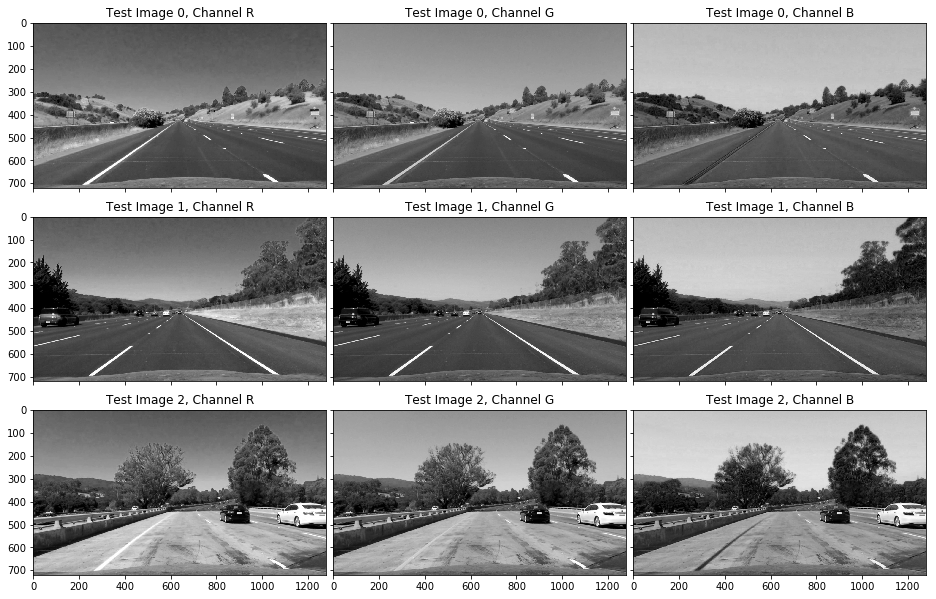

In [164]:
display(
    color.split_channels(test_image_subset),
    cols=3,
    titles=[
        'Test Image {0}, Channel {1}'.format(num, color)
        for num in range(len(test_image_subset))
        for color in 'RGB'
    ]
)

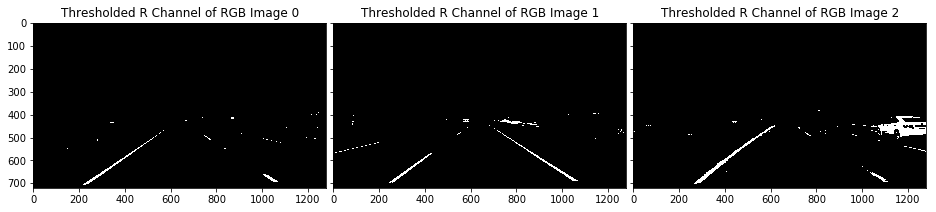

In [165]:
binary_rgb = color.binary(test_image_subset, channel=0, threshold=(220, 255))

display(
    binary_rgb,
    titles=[
        'Thresholded R Channel of RGB Image {0}'.format(i)
        for i in range(len(test_image_subset))
    ]
)

### HLS

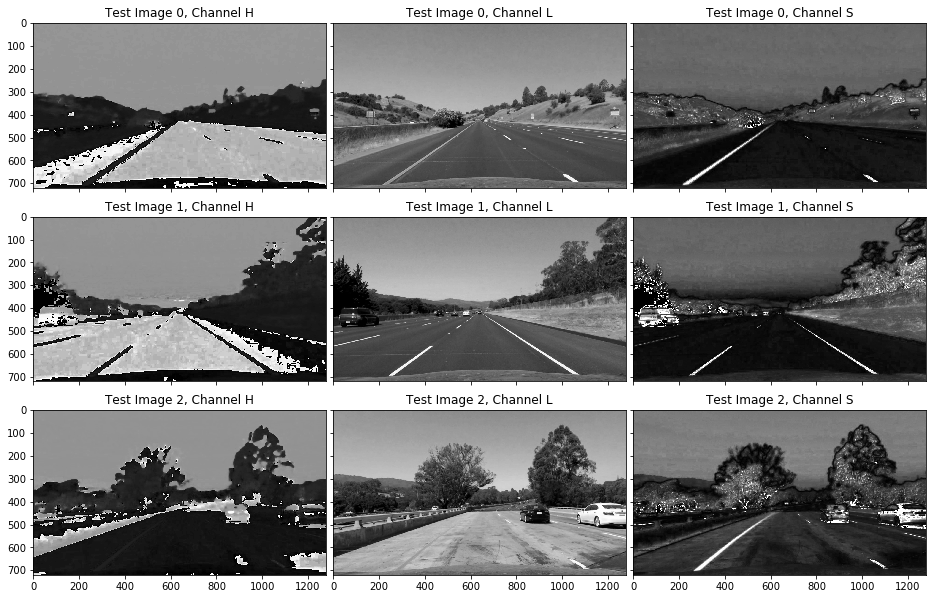

In [166]:
test_image_subset_hls = [cv2.cvtColor(img, cv2.COLOR_RGB2HLS) for img in test_image_subset]

display(
    color.split_channels(test_image_subset_hls),
    cols=3,
    titles=[
        'Test Image {0}, Channel {1}'.format(num, color)
        for num in range(len(test_image_subset_hls))
        for color in 'HLS'
    ]
)

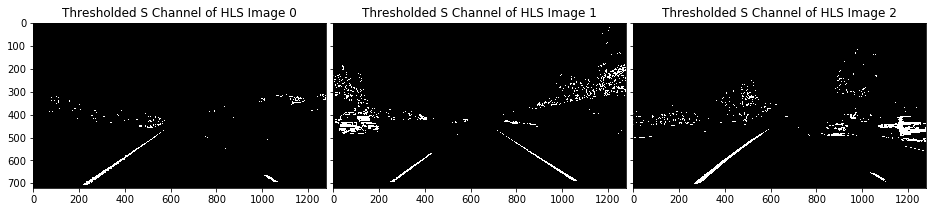

In [167]:
binary_hls = color.binary(test_image_subset_hls, channel=2, threshold=(150, 255))

display(
    binary_hls,
    titles=[
        'Thresholded S Channel of HLS Image {0}'.format(i)
        for i in range(len(test_image_subset_hls))
    ]
)

### HSV

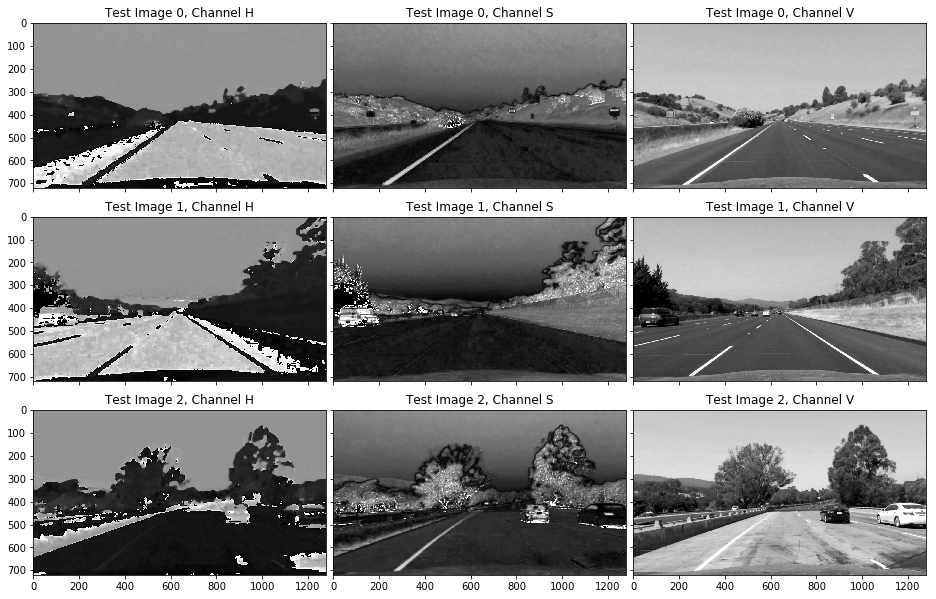

In [168]:
test_image_subset_hsv = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in test_image_subset]

display(
    color.split_channels(test_image_subset_hsv),
    cols=3,
    titles=[
        'Test Image {0}, Channel {1}'.format(num, color)
        for num in range(len(test_image_subset_hsv))
        for color in 'HSV'
    ]
)

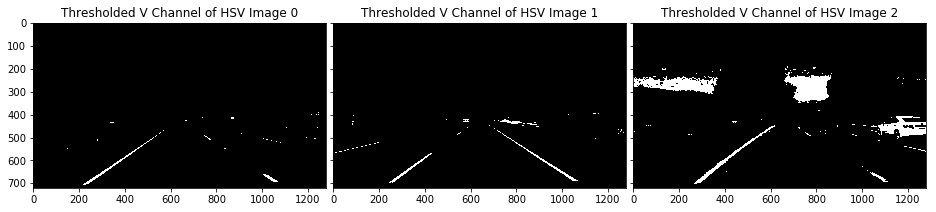

In [169]:
binary_hsv = color.binary(test_image_subset_hsv, channel=2, threshold=(220, 255))

display(
    binary_hsv,
    titles=[
        'Thresholded V Channel of HSV Image {0}'.format(i)
        for i in range(len(test_image_subset_hsv))
    ]
)

### Lab

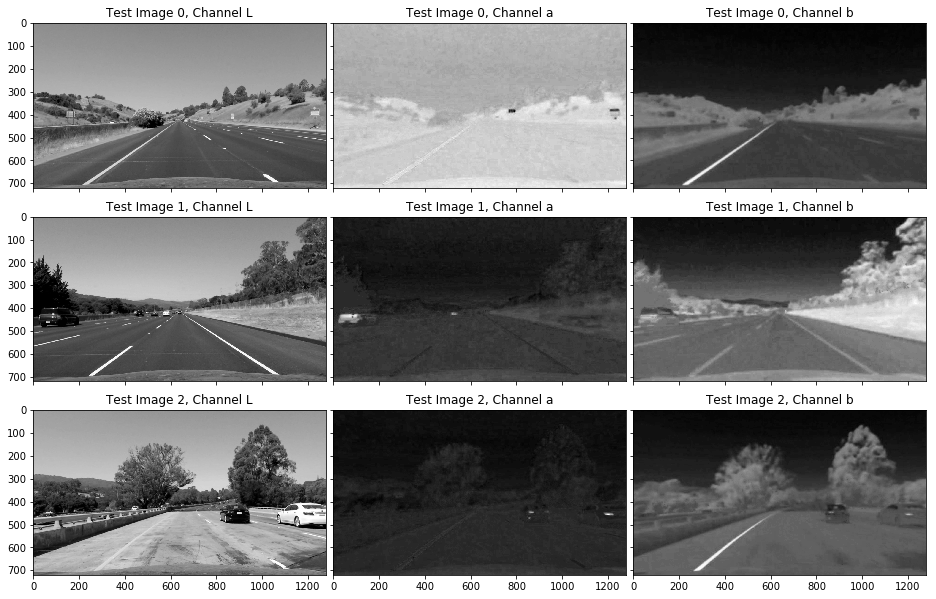

In [170]:
test_image_subset_lab = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in test_image_subset]

display(
    color.split_channels(test_image_subset_lab),
    cols=3,
    titles=[
        'Test Image {0}, Channel {1}'.format(num, color)
        for num in range(len(test_image_subset_lab))
        for color in 'Lab'
    ]
)

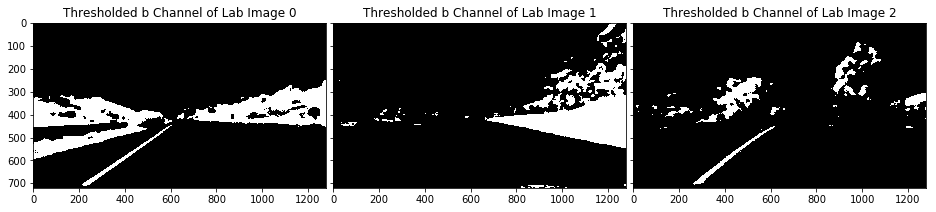

In [171]:
binary_lab = color.binary(test_image_subset_lab, channel=2, threshold=(145, 255))

display(
    binary_lab,
    titles=[
        'Thresholded b Channel of Lab Image {0}'.format(i)
        for i in range(len(test_image_subset_lab))
    ]
)

### YUV

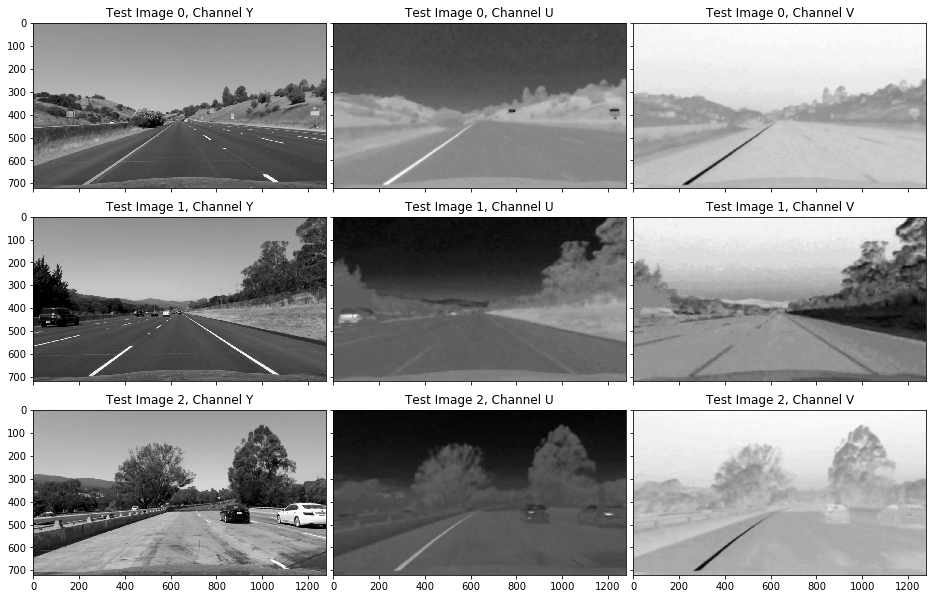

In [172]:
test_image_subset_yuv = [cv2.cvtColor(img, cv2.COLOR_RGB2YUV) for img in test_image_subset]

display(
    color.split_channels(test_image_subset_yuv),
    cols=3,
    titles=[
        'Test Image {0}, Channel {1}'.format(num, color)
        for num in range(len(test_image_subset_yuv))
        for color in 'YUV'
    ]
)

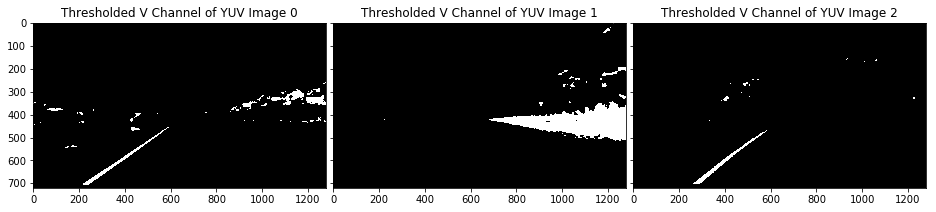

In [173]:
display(
    color.binary(test_image_subset_yuv, channel=2, threshold=(0, 100)),
    titles=[
        'Thresholded V Channel of YUV Image {0}'.format(i)
        for i in range(len(test_image_subset_yuv))
    ]
)

As can be seen, using YUV doesn't provide any benefits over the other color spaces above.

### Combination of RGB, HLS, HSV and Lab

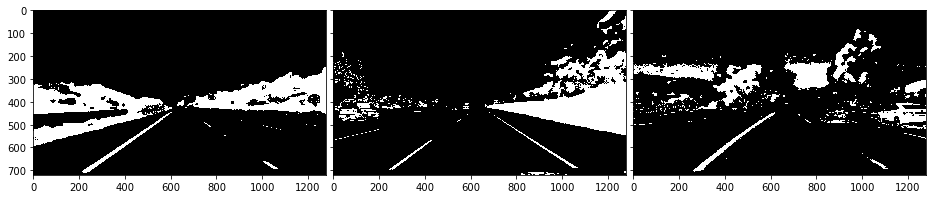

In [174]:
combined = color.combine_thresholds(binary_rgb, binary_hls, binary_hsv, binary_lab)

display(combined)

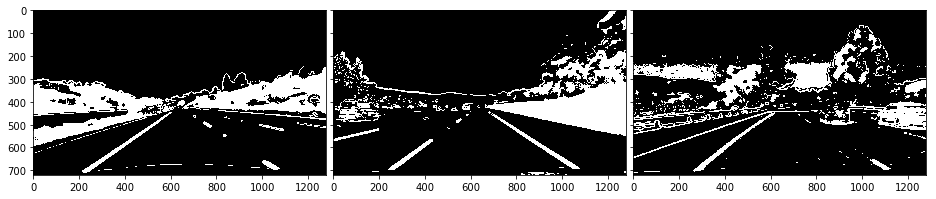

In [175]:
combined_with_strobel = color.combine_thresholds(combined, test_sobelxy)

display(combined_with_strobel)

Combining the color channel thresholds with the Sobel edge detection apparently yields stronger lane lines and therefore more robust results.

## Perspective Transformation

Redisplay undistorted base images

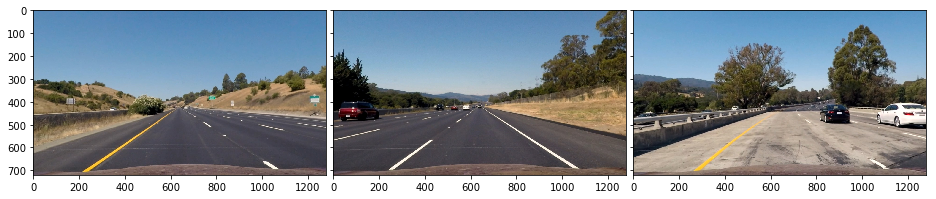

In [177]:
display(test_image_subset)

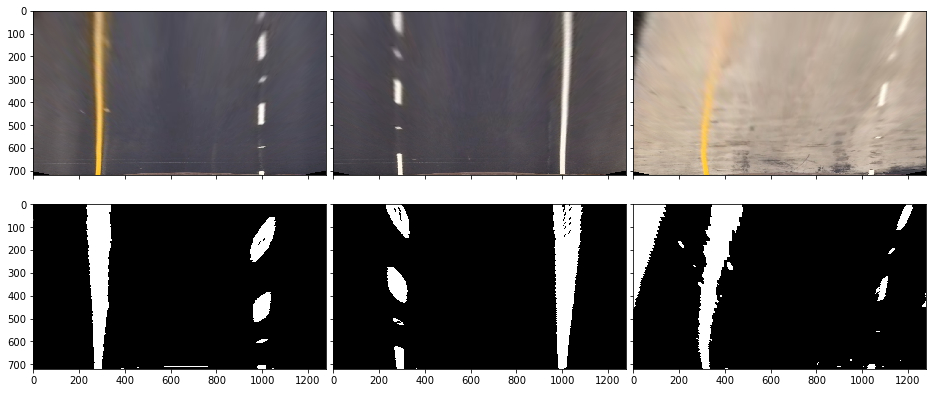

In [180]:
source_points = np.float32((
    (230, 700), (1075, 700), (693, 455), (588, 455)
))
destination_points = np.float32((
    (280, 720), (1000, 720), (1000, 0), (280, 0)
))

warped = [warp.warp(img, source_points, destination_points) for img in test_image_subset]
warped_binary = [warp.warp(img, source_points, destination_points) for img in combined_with_strobel]
display(warped + warped_binary, cols=len(warped))

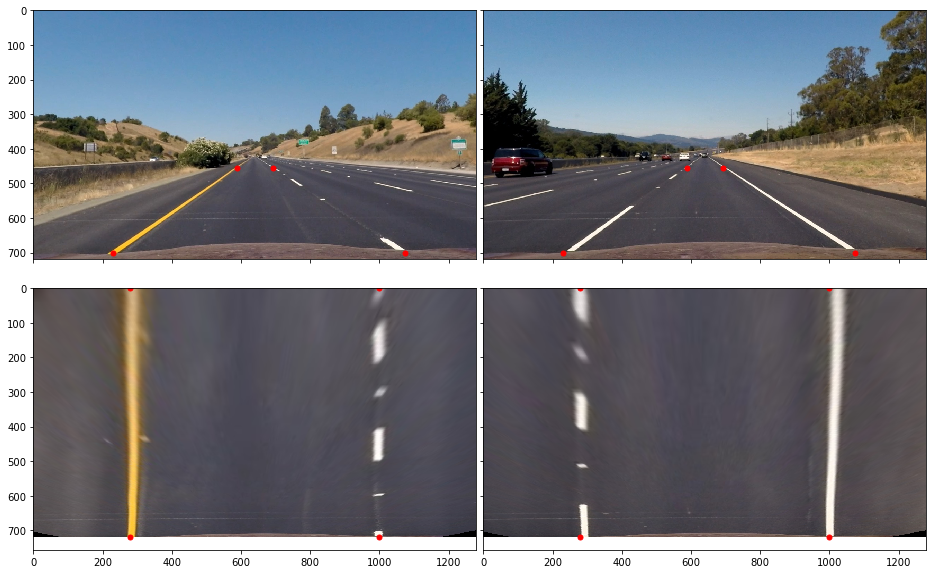

In [198]:
def draw_dots(dots):
    def _draw_dots(plot, index):
        for dot in dots[index]:
            plot.plot(dot[0], dot[1], 'r.', ms=10)
    return _draw_dots

display(
    test_image_subset[:2] + warped[:2],
    cols=2,
    callback=draw_dots([source_points, source_points, destination_points, destination_points])
)